# Setup

## Installations

In [1]:
! pip install datasets transformers[sentencepiece]

## Libraries

In [2]:
from datasets import load_dataset

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

import textwrap

from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from keras.preprocessing import sequence
from keras.utils import np_utils

# Emotions Dataset

https://huggingface.co/datasets/emotion

## Load

In [3]:
raw_datasets = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
raw_datasets['test'].features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

In [6]:
label_text = {i: label for i, label in enumerate(raw_datasets['test'].features['label'].names)}
label_text

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

## To Pandas

In [7]:
df = {}
for dataset in ['train', 'validation', 'test']:
  df[dataset] = pd.DataFrame.from_records(zip(raw_datasets[dataset]['text'], 
                                              raw_datasets[dataset]['label']), 
                                          columns=['text', 'label'])
  
df['train'].sample(5)

,text,label
8768,i just feel like a very successful year old,1
15293,i feel like im being greedy when i say i want ...,3
2666,i expect and i feel content with that,1
10598,i am feeling very bitter about it all,3
4519,i don t always have access to when i m feeling...,0


## Some Examples

In [8]:
for _, (text, label) in df['train'].sample(10).iterrows():
  print('\n'.join(textwrap.wrap(text, 100)))
  print(f'-> {label_text[label]}\n')

i can run and it feels amazing
-> surprise

i chose to share that little personal snippet in my phone because i know i m not the only one that
feels this way and i know i m not the only one that was petrified to face it
-> fear

im wanting you to look at me that it makes people feel ok to ask questions
-> joy

i left feeling pretty chuffed with my finds
-> joy

i feel much more relaxed i am enjoying life again i am very comfortable being myself and i never
stop dreaming and tackling new projects
-> joy

im feeling particularly awful about my language learning capabilities this week
-> sadness

my mother did not come home till late at night ages ago anyway if i dont know where my parents are
and when theyll be back i start thinking that perhaps they have had an accident and are perhaps dead
-> fear

i feel it must have been the violent dream i had to snap myself awake from a difficult dream of my
mother representing anyone and everyone and self violence universal but beautiful in its me

## Class Distribution

In [9]:
for name, dataset in df.items():
  print(name)
  print(dataset['label'].map(label_text).value_counts())

train
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64
validation
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: label, dtype: int64
test
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: label, dtype: int64


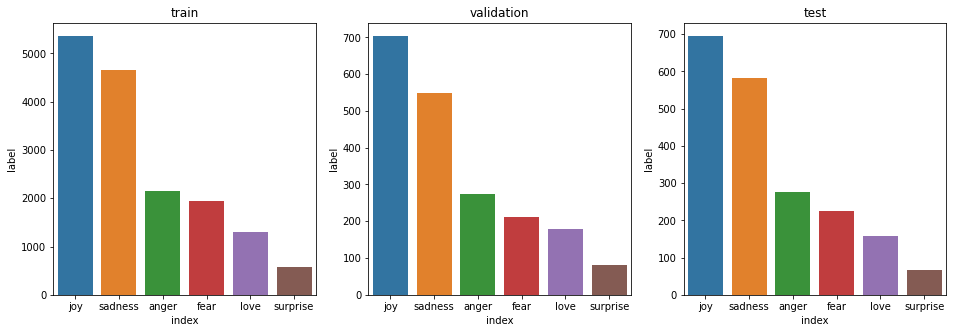

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, (name, dataset) in enumerate(df.items()):
  sns.barplot(
    data=dataset['label'].map(label_text).value_counts().to_frame().reset_index(),
    x="index",
    y="label",
    ax = ax[i]
  )
  ax[i].set_title(name)

## OneHot Encoding

In [11]:
y_train = np_utils.to_categorical(df['train']['label'])
y_test = np_utils.to_categorical(df['test']['label'])
num_classes = y_test.shape[1]

In [12]:
print(y_train.shape, y_test.shape)
print(y_train[:4])

(16000, 6) (2000, 6)
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


# Transformers

- State-of-the-art NLP
- [HuggingFace](https://huggingface.co/)
- Encoder with Self-Attention
- Decoder with Attention

<img src="https://lesdieuxducode.com/images/blog/pauldenoyes@expaceocom/BERT-Transformer-Architecture-Globale.png"/>

# [Distilbert](https://huggingface.co/distilbert-base-uncased)
- Light _Bidirectional Encoder Representations from Transformers_(BERT) model

### Tokenizer

In [13]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [14]:
tokenizer.tokenize(df['test']['text'][333])

['i',
 'feel',
 'check',
 'the',
 'wonder',
 'in',
 'all',
 'that',
 'you',
 'see',
 'you',
 've',
 'got',
 'to',
 'get',
 'loving',
 'un',
 '##con',
 '##ditional',
 '##ly']

In [15]:
tokenizer.tokenize("learning about transformer networks is breathtaking")

['learning',
 'about',
 'transform',
 '##er',
 'networks',
 'is',
 'breath',
 '##taking']

### Tokenize Dataset

In [16]:
def tokenize_dataset(dataset):
    encoded = tokenizer(
        dataset['text'],
        padding=True,
        truncation=True,
        return_tensors='np',
    )
    return encoded.data

tokenized_datasets = {
    split: tokenize_dataset(raw_datasets[split]) for split in raw_datasets.keys()
}

In [17]:
tokenized_datasets['test']

{'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'input_ids': array([[  101, 10047,  3110, ...,     0,     0,     0],
        [  101, 10047,  2039, ...,     0,     0,     0],
        [  101,  1045,  2196, ...,     0,     0,     0],
        ...,
        [  101,  1045,  2514, ...,     0,     0,     0],
        [  101, 10047,  3110, ...,     0,     0,     0],
        [  101,  1045,  2514, ...,     0,     0,     0]])}

## Model

In [18]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels = raw_datasets['test'].features['label'].num_classes # 6
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [19]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  4614      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,958,086
Trainable params: 66,958,086
Non-trainable params: 0
_________________________________________________________________


## Optimizer

In [20]:
batch_size = 8
num_epochs = 3

num_train_steps = (len(tokenized_datasets['train']['input_ids']) // batch_size) * num_epochs

lr_scheduler = optimizers.schedules.PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.,
    decay_steps=num_train_steps
    )


opt = optimizers.Adam(learning_rate=lr_scheduler)

## Loss

In [21]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss,  metrics=['accuracy'])

## Training

In [22]:
%%time
hitory = model.fit(tokenized_datasets['train'],
                   np.array(raw_datasets['train']['label']),
                   validation_data=(tokenized_datasets['validation'], 
                                    np.array(raw_datasets['validation']['label'])),
                   batch_size=batch_size,
                   epochs=num_epochs)

Epoch 1/3
2000/2000 [==============================] - 124s 59ms/step - loss: 0.3722 - accuracy: 0.8705 - val_loss: 0.1538 - val_accuracy: 0.9305
Epoch 2/3
2000/2000 [==============================] - 119s 59ms/step - loss: 0.1217 - accuracy: 0.9429 - val_loss: 0.1394 - val_accuracy: 0.9370
Epoch 3/3
2000/2000 [==============================] - 117s 58ms/step - loss: 0.0815 - accuracy: 0.9566 - val_loss: 0.1316 - val_accuracy: 0.9405
CPU times: user 5min 43s, sys: 4.99 s, total: 5min 48s
Wall time: 6min 28s


## Model Evaluation

In [23]:
scores = model.evaluate(tokenized_datasets['test'], np.array(raw_datasets['test']['label']), verbose=0)
print("Transformer Error: %.2f%%" % (100-scores[1]*100))

Transformer Error: 6.75%


# Confusion Matrix

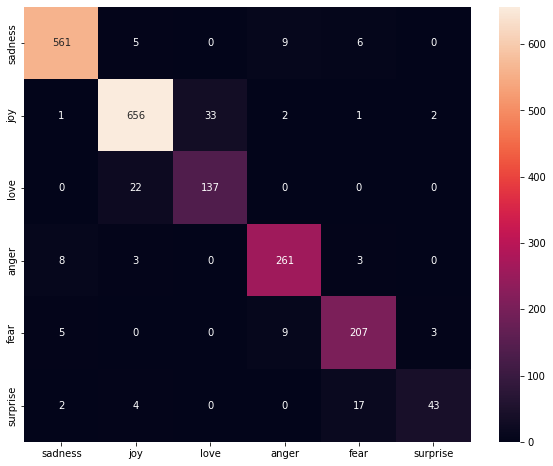

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))

predictions = model.predict(tokenized_datasets['test'])

cm = confusion_matrix(np.array(raw_datasets['test']['label']), 
                      np.argmax([p for p in predictions.values()][0], axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ticks = np.arange(0.5,6.5,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(label_text.values())
ax.set_yticklabels(label_text.values())

plt.show()

❓ Try out the model

In [25]:
sentence = 'i feel intimidated nervous and overwhelmed and i shake like a leaf'

sentence = tokenizer(sentence,
                     padding=True,
                     truncation=True,
                     return_tensors='np').data

prediction = model.predict(sentence)

label_text[np.argmax([p for p in prediction.values()][0], axis=1)[0]]

'fear'